<div style="text-align: center;"> <img align=middle src="https://hyperpix.net/wp-content/uploads/2020/04/ford-v-ferrari-logo-font-free-download-856x484.jpg"> </div>

# Проект 7. "Ford vs Ferrari: определяем модель авто по фото"
### Выполнен Шашановым М. (SF-DST-76)

**Задачей данного проекта является построение модели классификации автомобилей по их фотографиям, всего 10 различных моделей.
<br>
Основная идея решения: взять предобученную на ImageNet нейронную сеть EfficientNet и дообучить под нашу задачу, т.е. применить Transfer Learning. Дообучение необходимо, поскольку при обучении исходной сети не использовались изображения этих моделей автомобилей. Плюсом данного метода является то, что обучение нейронной сети с нуля требует большого числа примеров изображений и долгого времени вычислений, что не подходит для выполнения данного проекта.**

In [1]:
# Импортируем необходимые библиотеки
import numpy as np
import pandas as pd
import pickle
import zipfile
import csv
import cv2
import sys
import os
import random
import time
import gc
import string
import pathlib
import itertools
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K

from tensorflow.keras import Sequential
from tensorflow.keras.activations import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.optimizers.schedules import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2

import car_class_kernel_module as km

import PIL
from PIL import ImageOps, ImageFilter, Image

import warnings
warnings.filterwarnings("ignore")
tf.get_logger().setLevel('WARNING')

In [2]:
# Установим дефолтный размер графиков и подписей
from pylab import rcParams

plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['font.size'] = 12
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['figure.titlesize'] = 'medium'

# Графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

In [3]:
!pip freeze > requirements.txt

In [4]:
# Проверим версии основных библиотек
print('Python       :', sys.version.split('\n')[0].split(' | ')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)
print('PIL          :', PIL.__version__)

Python       : 3.7.12
Numpy        : 1.21.6
Tensorflow   : 2.6.4
Keras        : 2.6.0
PIL          : 9.1.1


Работаем с Tensorflow v2

In [5]:
# Проверка GPU
!nvidia-smi -L
tf.test.gpu_device_name()

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-415e05e7-6236-d11b-c02d-65f7fec9509f)


2022-06-29 10:40:50.611280: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-29 10:40:50.672172: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-29 10:40:50.777633: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-29 10:40:50.778456: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

'/device:GPU:0'

ysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-29 10:40:52.808838: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-29 10:40:52.809432: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /device:GPU:0 with 15403 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [6]:
# Очищаем сессию Tensorflow
K.clear_session()

# Загрузка и исследование данных

Загрузим и проведем разведывательный анализ (EDA) исходных изображений. В данном проекте (соревнованияи Kaggle) предоставляются размеченные обучающие данные и неразмеченные тестовые в архивированном виде.

In [7]:
# Исходные данные и директории
print(os.listdir('..'))
print(os.listdir('../input/'))
print(os.listdir('../input/sf-dl-car-classification/'))

['lib', 'input', 'usr', 'working']
['sf-dl-car-classification']
['train.zip', 'sample-submission.csv', 'test.zip', 'train.csv']


In [8]:
DATA_PATH = '../input/sf-dl-car-classification/' # директория с исходными данными
PATH = '../working/car/' # рабочая директория для распакованных изображений
MODELS_PATH = '../working/saved_models/' # директория для сохранения состояния модели после разных эпох обучения

In [9]:
# Создание директорий
os.makedirs(MODELS_PATH, exist_ok=True, mode=0o777)
print(os.path.exists(MODELS_PATH))
os.makedirs(PATH, exist_ok=True, mode=0o777)
print(os.path.exists(PATH))

True
True


In [10]:
# %%time
# Распаковываем картинки
# # Will unzip the files so that you can see them
# for data_zip in ['train.zip', 'test.zip']:
#     with zipfile.ZipFile(DATA_PATH+data_zip,"r") as z:
#         z.extractall(PATH)
# print(os.listdir(PATH))

In [11]:
%%time
# Распаковываем картинки
!unzip -q {DATA_PATH + 'train.zip'} -d {PATH}
!unzip -q {DATA_PATH + 'test.zip'} -d {PATH}
print(os.listdir(PATH))

['train', 'test_upload']
CPU times: user 565 ms, sys: 148 ms, total: 713 ms
Wall time: 34.7 s


In [12]:
# Пути к изображениям для обучения и предсказания
train_path = PATH + 'train/'
sub_path = PATH + 'test_upload/'

In [13]:
# Загрузка табличных данных
train_df = pd.read_csv(DATA_PATH+'train.csv')
submission_df = pd.read_csv(DATA_PATH+'sample-submission.csv')
train_df_init = train_df.copy()

В train_df (таблица с изображениями для обучения) столбцы Id и Category, пропусков нет

In [14]:
data = train_df
display(data.info(), data.isna().sum(), data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


None

Id          0
Category    0
dtype: int64

,Id,Category
0,100155.jpg,0
1,100306.jpg,0
2,100379.jpg,0
3,100380.jpg,0
4,100389.jpg,0


В submission_df (таблица с изображениями для предсказания) столбцы Id и Category, пропусков нет

In [15]:
data = submission_df
display(data.info(), data.isna().sum(), data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6675 entries, 0 to 6674
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        6675 non-null   object
 1   Category  6675 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 104.4+ KB


None

Id          0
Category    0
dtype: int64

,Id,Category
0,305108.jpg,0
1,295075.jpg,0
2,31197.jpg,0
3,93598.jpg,0
4,87877.jpg,0


Выведем информацию об изображениях: расположение по директориям и пр.

In [16]:
train_filenames_list = []
train_categories_list = []
train_list = os.listdir(train_path)
test_list = os.listdir(sub_path)
print(len(train_list), len(test_list), train_df.shape[0])
print(train_list)
train_count = 0
for dir_path in train_list:
    train_filenames = os.listdir(train_path + dir_path)
    train_count += len(train_filenames)
    train_filenames_list += train_filenames
    train_categories_list += [int(dir_path)] * len(train_filenames)
    print(train_filenames[:5])

print(train_count == train_df.shape[0])
print(test_list[:10])

10 6675 15561
['0', '6', '5', '7', '9', '3', '4', '8', '2', '1']
['15164.jpg', '137918.jpg', '183046.jpg', '264783.jpg', '238206.jpg']
['271994.jpg', '12017.jpg', '179603.jpg', '28573.jpg', '132752.jpg']
['208968.jpg', '270851.jpg', '232014.jpg', '258480.jpg', '258686.jpg']
['171534.jpg', '174037.jpg', '256119.jpg', '231393.jpg', '198191.jpg']
['16754.jpg', '127914.jpg', '247339.jpg', '135026.jpg', '20505.jpg']
['260888.jpg', '117715.jpg', '155237.jpg', '116953.jpg', '119319.jpg']
['167534.jpg', '223650.jpg', '256542.jpg', '27902.jpg', '247184.jpg']
['134807.jpg', '171377.jpg', '278253.jpg', '123818.jpg', '171100.jpg']
['192692.jpg', '241940.jpg', '147340.jpg', '196393.jpg', '182943.jpg']
['250450.jpg', '15467.jpg', '165176.jpg', '29489.jpg', '286042.jpg']
True
['308367.jpg', '297897.jpg', '77477.jpg', '301314.jpg', '32094.jpg', '295410.jpg', '69978.jpg', '307407.jpg', '32903.jpg', '3753.jpg']


Далее проверим, что изображения в директории "train/" соответствуют данным в датафрейме train_df

In [17]:
train_df_test = pd.DataFrame({
    'Id' : train_filenames_list,
    'Category' : train_categories_list,
}, columns=['Id', 'Category'])

train_df.sort_values(by=['Id'], inplace=True, ignore_index=True)
train_df_test.sort_values(by=['Id'], inplace=True, ignore_index=True)
train_df.equals(train_df_test)

True

Добавим и проанализируем дополнительные признаки изображений, такие, как формат, размер и пр.

In [18]:
train_df = train_df_init
train_df['Path'] = train_df.apply(lambda row: 'train/' + str(row['Category']) + '/' + row['Id'], axis=1)

In [19]:
def add_image_param_columns(df):
    df['Format'] = df['Path'].apply(lambda img_path: PIL.Image.open(PATH+img_path).format)
    df['Mode'] = df['Path'].apply(lambda img_path: PIL.Image.open(PATH+img_path).mode)
    df['Width'] = df['Path'].apply(lambda img_path: PIL.Image.open(PATH+img_path).width)
    df['Height'] = df['Path'].apply(lambda img_path: PIL.Image.open(PATH+img_path).height)
    df['Size'] = df['Path'].apply(lambda img_path: os.path.getsize(PATH+img_path))
    df['HeightDivWidth'] = df['Height'].values / df['Width'].values
    df['NumPixels'] = df['Height'].values * df['Width'].values

In [20]:
add_image_param_columns(train_df)
display(train_df.head())

,Id,Category,Path,Format,Mode,Width,Height,Size,HeightDivWidth,NumPixels
0,100155.jpg,0,train/0/100155.jpg,JPEG,RGB,640,427,77071,0.667188,273280
1,100306.jpg,0,train/0/100306.jpg,JPEG,RGB,640,480,61952,0.750000,307200
2,100379.jpg,0,train/0/100379.jpg,JPEG,RGB,640,480,87498,0.750000,307200
3,100380.jpg,0,train/0/100380.jpg,JPEG,RGB,640,480,95670,0.750000,307200
4,100389.jpg,0,train/0/100389.jpg,JPEG,RGB,640,480,101641,0.750000,307200


In [21]:
submission_df.Category = 0
submission_df['Path'] = submission_df.apply(lambda row: 'test_upload/' + row['Id'], axis=1)
add_image_param_columns(submission_df)
display(submission_df.head())

,Id,Category,Path,Format,Mode,Width,Height,Size,HeightDivWidth,NumPixels
0,305108.jpg,0,test_upload/305108.jpg,JPEG,RGB,639,480,94496,0.751174,306720
1,295075.jpg,0,test_upload/295075.jpg,JPEG,RGB,640,480,130967,0.750000,307200
2,31197.jpg,0,test_upload/31197.jpg,JPEG,RGB,360,480,38169,1.333333,172800
3,93598.jpg,0,test_upload/93598.jpg,JPEG,RGB,640,384,93105,0.600000,245760
4,87877.jpg,0,test_upload/87877.jpg,JPEG,RGB,640,427,52522,0.667188,273280


Пример изображения из обучающей выборки, размер 640 пикселей по ширине и 480 по высоте

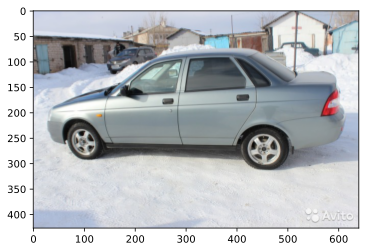

In [22]:
img_path = PATH + train_df['Path'].values[0]
img = PIL.Image.open(img_path)
plt.imshow(img)

## Format

In [23]:
col = 'Format'
km.print_col_info(train_df[col])
km.print_col_info(submission_df[col])

JPEG    100.0 %
Name: Format, dtype: object

Num of missing values: 0


JPEG    100.0 %
Name: Format, dtype: object

Num of missing values: 0


Все изображения в формате JPEG

## Mode

In [24]:
col = 'Mode'
km.print_col_info(train_df[col], 2)
km.print_col_info(submission_df[col], 2)

RGB    99.97 %
L       0.03 %
Name: Mode, dtype: object

Num of missing values: 0


RGB    99.97 %
L       0.03 %
Name: Mode, dtype: object

Num of missing values: 0


In [25]:
display(train_df[col].value_counts())
display(submission_df[col].value_counts())

RGB    15556
L          5
Name: Mode, dtype: int64

RGB    6673
L         2
Name: Mode, dtype: int64

Среди изображений встречается несколько черно-белых (L), остальные цветные (RGB).
<br>
Посмотрим подробнее на черно-белые:

In [26]:
train_df_black_and_white = train_df[train_df['Mode'].str.contains('L')]
display(train_df_black_and_white)

,Id,Category,Path,Format,Mode,Width,Height,Size,HeightDivWidth,NumPixels
44,104571.jpg,0,train/0/104571.jpg,JPEG,L,640,480,92881,0.750000,307200
852,202758.jpg,0,train/0/202758.jpg,JPEG,L,640,480,117145,0.750000,307200
1355,267112.jpg,0,train/0/267112.jpg,JPEG,L,480,480,36423,1.000000,230400
7691,255163.jpg,4,train/4/255163.jpg,JPEG,L,480,480,63002,1.000000,230400
13917,254668.jpg,8,train/8/254668.jpg,JPEG,L,640,309,34224,0.482812,197760


In [27]:
submission_df_black_and_white = submission_df[submission_df['Mode'].str.contains('L')]
display(submission_df_black_and_white)

,Id,Category,Path,Format,Mode,Width,Height,Size,HeightDivWidth,NumPixels
1943,76970.jpg,0,test_upload/76970.jpg,JPEG,L,640,360,64828,0.562500,230400
2525,84187.jpg,0,test_upload/84187.jpg,JPEG,L,639,480,68507,0.751174,306720


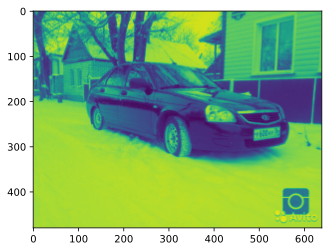

In [28]:
img_path = PATH + submission_df_black_and_white['Path'].values[1]
img = PIL.Image.open(img_path)
plt.imshow(img)

Удаление или конвертация таких изображений в RGB не улучшает качества предсказания, поэтому оставим их как есть в обучающей и тестовых выборках

## Width

In [29]:
col = 'Width'
km.print_col_info(train_df[col])
km.print_col_info(submission_df[col])

640    85.1 %
360     6.4 %
604     1.9 %
270     1.4 %
Name: Width, dtype: object

Num of missing values: 0


640    85.4 %
360     5.9 %
604     2.1 %
480     1.4 %
Name: Width, dtype: object

Num of missing values: 0


In [30]:
print([train_df[col].min(), train_df[col].max(), round(train_df[col].mean())])
print([submission_df[col].min(), submission_df[col].max(), round(submission_df[col].mean())])

[130, 640, 607]
[173, 640, 609]


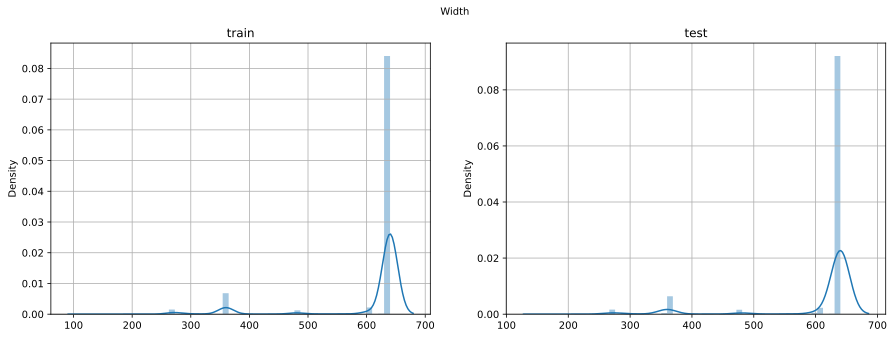

In [31]:
km.plot_num_col_unified(train_df, submission_df, col)

Большинство изображений имеет максимальную ширину, равную 640 пикселей (в среднем 610)

## Height

In [32]:
col = 'Height'
km.print_col_info(train_df[col])
km.print_col_info(submission_df[col])

480    62.0 %
360    17.4 %
427     3.5 %
384     2.6 %
Name: Height, dtype: object

Num of missing values: 0


480    61.9 %
360    17.2 %
427     3.2 %
384     2.8 %
Name: Height, dtype: object

Num of missing values: 0


In [33]:
print([train_df[col].min(), train_df[col].max(), round(train_df[col].mean())])
print([submission_df[col].min(), submission_df[col].max(), round(submission_df[col].mean())])

[97, 480, 445]
[130, 480, 445]


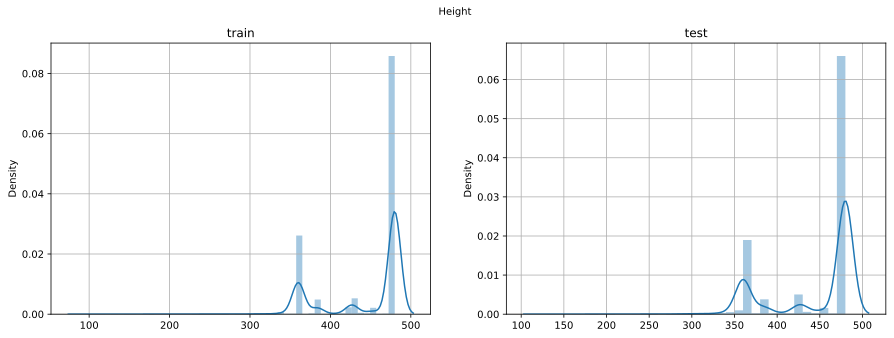

In [34]:
km.plot_num_col_unified(train_df, submission_df, col)

Большая часть изображений имеет высоту 480 пикселей, в среднем 440. Также довольно высокий процент изображений имеют высоту 360 пикселей

## Size

In [35]:
col = 'Size'
km.print_col_info(train_df[col], 3)
km.print_col_info(submission_df[col], 3)

67874    0.026 %
71278    0.026 %
61958    0.026 %
73200    0.026 %
Name: Size, dtype: object

Num of missing values: 0


55205    0.045 %
70847    0.045 %
87801    0.045 %
88417    0.045 %
Name: Size, dtype: object

Num of missing values: 0


In [36]:
print([train_df[col].min(), train_df[col].max(), round(train_df[col].mean())])
print([submission_df[col].min(), submission_df[col].max(), round(submission_df[col].mean())])

[5348, 156080, 76120]
[10597, 169476, 76704]


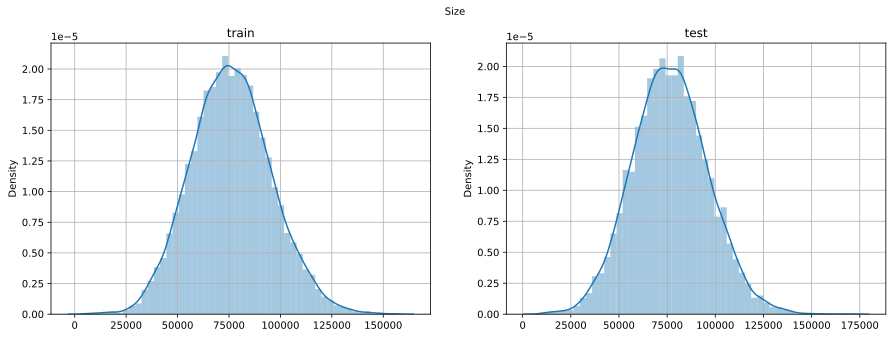

In [37]:
km.plot_num_col_unified(train_df, submission_df, col)

Размер изображений имеет нормальное распределение как в обучающей выборке, так и в тестовой

## Category

In [38]:
col = 'Category'
km.print_col_info(train_df[col], 1, 10)

1    12.7 %
8    11.3 %
6    11.1 %
5    10.5 %
0    10.4 %
3     9.8 %
2     9.4 %
4     9.0 %
9     8.1 %
7     7.8 %
Name: Category, dtype: object

Num of missing values: 0


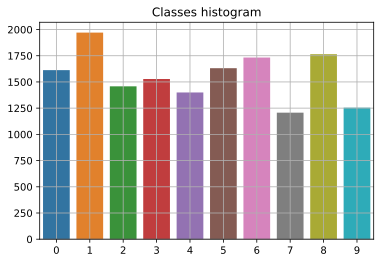

In [39]:
km.plot_classes_hist(train_df[col])

Распределение классов в обучающей выборке достаточно равномерное, для обучения это хорошо

In [40]:
def get_num_files(path):
    tree = os.walk(path)
    num_files = 0
    for dir in tree:
        num_files += len(dir[2])
    return num_files


def delete_files(filenames, dir=PATH):
    for filename in filenames:
        os.remove(dir+filename)

In [41]:
# n1 = get_num_files(train_path)
# delete_files(train_df_black_and_white['Path'].values.tolist())
# n2 = get_num_files(train_path)
# print(n1 - n2)

# Основные настройки

In [42]:
# Установим основные настройки
EPOCHS               = 10  # Эпохи обучения
BATCH_SIZE           = 32 # уменьшаем batch если сеть большая, иначе не помещается в память на GPU
LR                   = 1e-3 # Learning Rate
VAL_SPLIT            = 0.2 # Сколько данных выделяем на тест = 20%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = (160, 215) # Какого размера подаем изображения в сеть, для отладки (90, 120), (135, 180), (320, 427)
IMG_CHANNELS         = 3 # У RGB 3 канала
INPUT_SHAPE          = (*IMG_SIZE, IMG_CHANNELS)

# Устаналиваем конкретное значение random seed для воспроизводимости
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
PYTHONHASHSEED = RANDOM_SEED
tf.random.set_seed(RANDOM_SEED)

# Подготовка данных

In [43]:
# Названия моделей автомобилей
class_names = [
  'Приора', #0
  'Ford Focus', #1
  'Самара', #2
  'ВАЗ-2110', #3
  'Жигули', #4
  'Нива', #5
  'Калина', #6
  'ВАЗ-2109', #7
  'Volkswagen Passat', #8
  'ВАЗ-21099' #9
]
class_names_dict = dict(zip(range(CLASS_NUM), class_names))
# pprint(class_names_dict)

Создаем генераторы изображений, т.е. объекты ImageDataGenerator, указав какие аугментации (преобразования изображений) необходимо выполнить.
Далее при обучении мы каждый раз "показываем" нейронной сети немного разные варианты одной и той же картинки. Обучение с аугментациями данных - это один из способов регуляризации (повышения обобщающей способности модели), особенно при работе с небольшим датасетом для обучения.
<br>
Используются следующие виды аугментаций:
* horizontal_flip, отражение по горизонтали с вероятностью 50%
* rotation_range, случайный поворот в пределах 10 градусов
* shear_range, случайный сдвиг с искажением
* brightness_range, случайное изменение яркости

Валидационные и тестовые изображения оставим без аугментации. 
<br>
Затем укажем, откуда брать изображения. При этом применим интерполяцию изображений типа 'hamming' для улучшения качества обучения и последующего предсказания.

In [44]:
image_interpolation = 'hamming'

train_datagen = ImageDataGenerator(
#     rescale=1/255,
    validation_split=VAL_SPLIT,

    # ниже параметры аугментаций:
    horizontal_flip=True,
    rotation_range=10,
    shear_range=0.2,
    brightness_range=(0.8, 1.2),
)

val_datagen = ImageDataGenerator(
#     rescale=1/255,
    validation_split=VAL_SPLIT,
)

sub_datagen = ImageDataGenerator(
#     rescale=1/255
)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    interpolation=image_interpolation,
    shuffle=True,
    seed=RANDOM_SEED,
    subset='training'
)

val_generator = val_datagen.flow_from_directory(
    train_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    interpolation=image_interpolation,
    shuffle=True,
    seed=RANDOM_SEED,
    subset='validation'
)

sub_generator = sub_datagen.flow_from_dataframe( 
    dataframe=submission_df,
    directory=sub_path,
    x_col='Id',
    y_col=None,
    class_mode=None,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    interpolation=image_interpolation,
    shuffle=False
)

Found 12452 images belonging to 10 classes.
Found 3109 images belonging to 10 classes.
Found 6675 validated image filenames.


Для примера первые несколько изображений каждого генератора

Train:


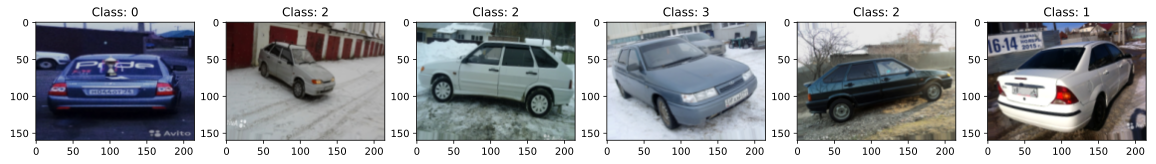

Val:


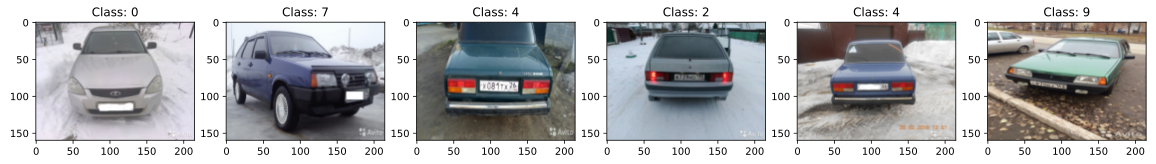

Sub:


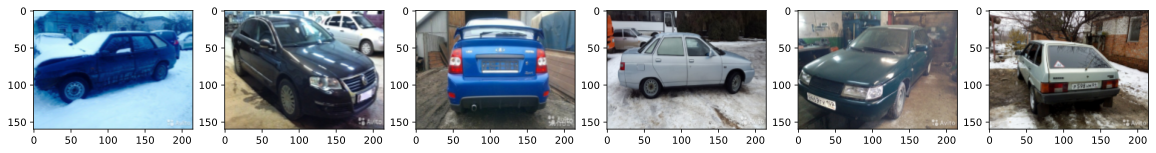

In [45]:
print('Train:')
km.show_first_images(train_generator)

print('Val:')
km.show_first_images(val_generator)

print('Sub:')
km.show_first_images(sub_generator, labels=False)

# Модель и ее обучение

Загружаем предобученную сеть EfficientNetB7, одну из наиболее эффективных на данный момент, отключая голову модели. В данной модели 813 слоев.


In [46]:
# Предобученная нейросеть EfficientNetB7 из модуля keras.applications
base_model = EfficientNetB7(weights='imagenet',
                            include_top=False,
                            input_shape=INPUT_SHAPE)

print(base_model.trainable)
print(f"Num layers: {len(base_model.layers)}")

2022-06-29 10:41:47.943803: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-29 10:41:47.944711: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-29 10:41:47.945373: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-29 10:41:47.946252: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-29 10:41:47.946926: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

258088960/258076736 [==============================] - 5s 0us/step
True
Num layers: 813


Устанавливаем новую «голову» (head):



In [47]:
# Строим модель
model = Sequential([
  base_model, 
  GlobalMaxPool2D(),
  Dropout(0.5),
  Dense(10)
])

Компилируем модель, используя ExponentialDecay в качестве техники управления Learning Rate. Включение параметра amsgrad немного улучшает результат предсказания.

In [48]:
model.compile(loss=CategoricalCrossentropy(from_logits=True),
              optimizer=Adam(ExponentialDecay(LR, 100, 0.9), amsgrad=True),
              metrics='accuracy')

После каждой эпохи обучения добавим некоторые действия (коллбэки):
* ModelCheckpoint сохраняет модель в файл best_model.h5 (в директории MODELS_PATH) в том случае, если значение val_accuracy после текущей эпохи достигло максимума. Далее эти веса модели можно подгрузить для финального предсказания.
* TerminateOnNaN прекращает обучение, если loss стал равным NaN.
* LambdaCallback позволяет задать действия после конца эпохи: сохранить веса модели и фактический Learning Rate

In [49]:
checkpoint = ModelCheckpoint(MODELS_PATH+'best_model.h5' , monitor='val_accuracy', verbose=1  , mode='max', save_best_only=True)
terminate = TerminateOnNaN()

def save_weights_after_each_epoch(epoch, logs):
    model_name = 'model_epoch_' + str(epoch) + '.h5'
    model.save_weights(MODELS_PATH+model_name)

each_epoch_1 = LambdaCallback(on_epoch_end=save_weights_after_each_epoch)

model_lr_list = []

def get_lr_after_each_epoch(epoch, logs):
    lr = K.eval(model.optimizer._decayed_lr(tf.float32))
    model_lr_list.append(lr)
    print(f"LR: {lr:.2e}\n")
    
each_epoch_2 = LambdaCallback(on_epoch_end=get_lr_after_each_epoch)

callbacks_list = [checkpoint, terminate, each_epoch_1, each_epoch_2]

In [50]:
# Сбросим генераторы на начало перед процессом обучения
train_generator.reset()
val_generator.reset()

In [51]:
lr = K.eval(model.optimizer._decayed_lr(tf.float32))
model_lr_list.append(lr)
print(f"Начальный Learning Rate:: {lr:.2e}\n")

Начальный Learning Rate:: 1.00e-03



In [52]:
%%time
# Обучаем модель
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=EPOCHS,
                    callbacks=callbacks_list)

2022-06-29 10:42:02.274661: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-06-29 10:42:33.103333: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
2022-06-29 10:42:38.881904: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.34GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-06-29 10:42:38.952653: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.58GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-06-29 10:42:39.310724: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.54GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory

128/390 [========>.....................] - ETA: 3:50 - loss: 1.7431 - accuracy: 0.4915

2022-06-29 10:44:32.387110: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.92GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-06-29 10:44:32.404936: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.94GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-06-29 10:44:32.427936: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.20GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-06-29 10:44:32.472392: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Alloc

390/390 [==============================] - 413s 965ms/step - loss: 0.9114 - accuracy: 0.7199 - val_loss: 0.3779 - val_accuracy: 0.8636

Epoch 00001: val_accuracy improved from -inf to 0.86362, saving model to ../working/saved_models/best_model.h5
LR: 6.63e-04

Epoch 2/10
390/390 [==============================] - 377s 967ms/step - loss: 0.2462 - accuracy: 0.9151 - val_loss: 0.1858 - val_accuracy: 0.9389

Epoch 00002: val_accuracy improved from 0.86362 to 0.93889, saving model to ../working/saved_models/best_model.h5
LR: 4.40e-04

Epoch 3/10
390/390 [==============================] - 378s 968ms/step - loss: 0.1374 - accuracy: 0.9511 - val_loss: 0.1410 - val_accuracy: 0.9550

Epoch 00003: val_accuracy improved from 0.93889 to 0.95497, saving model to ../working/saved_models/best_model.h5
LR: 2.91e-04

Epoch 4/10
390/390 [==============================] - 372s 953ms/step - loss: 0.0826 - accuracy: 0.9687 - val_loss: 0.1507 - val_accuracy: 0.9518

Epoch 00004: val_accuracy did not improve 

В процессе обучения происходит плавное уменьшение Learning Rate от шага к шагу, используя ExponentialDecay
(экспоненциальное затухание). Параметры затухания подбирались с целью улучшения точности предсказания

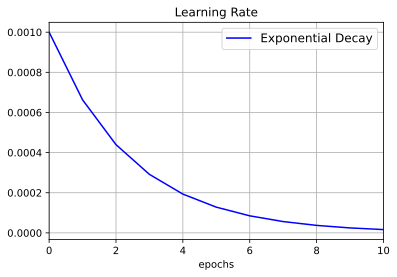

In [53]:
km.plot_learning_rate(model_lr_list, EPOCHS)

Посмотрим на графики обучения. Заметно, что точность на валидации стагнировала на последних эпохах, что похоже на переобучение,

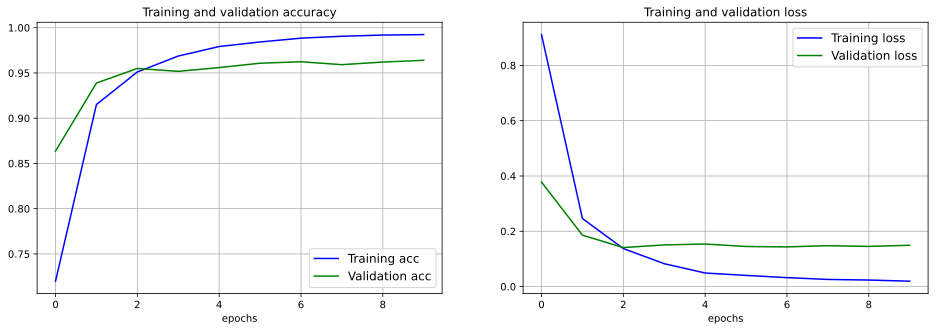

In [54]:
km.plot_history(history)

In [55]:
# Сохраненные модели
display(os.listdir(MODELS_PATH))

['best_model.h5',
 'model_epoch_9.h5',
 'model_epoch_5.h5',
 'model_epoch_7.h5',
 'model_epoch_8.h5',
 'model_epoch_4.h5',
 'model_epoch_3.h5',
 'model_epoch_0.h5',
 'model_epoch_1.h5',
 'model_epoch_2.h5',
 'model_epoch_6.h5']

# Предсказание на примере

Получить предсказание обученной модели для произвольного изображения можно таким образом:

In [56]:
# Загружаем лучшую по точности модель
model.load_weights(MODELS_PATH+'best_model.h5')
model.compile(loss=CategoricalCrossentropy(from_logits=True),
              optimizer=Adam(ExponentialDecay(LR, 100, 0.9), amsgrad=True),
              metrics='accuracy')

True
[215 160]


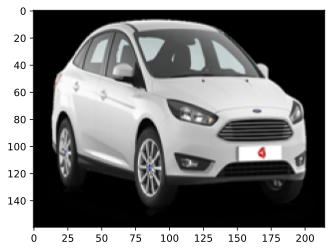

In [57]:
# Скачиваем изображение по URL, это модель Форд Фокус
!wget -q https://www.masmotors.ru/colors/ford-focus/1.png -P ../working/car/

sample_filename = '../working/car/1.png'
print(os.path.exists(sample_filename))    

#какого размера изображение модель принимает на вход?
img_size = np.array(model.input.shape)[[2, 1]]
print(img_size)

# загружаем изображение с помощью cv2
image = cv2.imread(sample_filename, cv2.IMREAD_COLOR)[..., ::-1] #cv2.imread читает в формате BGR, конвертируем в RGB с помощью индекса ::-1
image = cv2.resize(image, img_size)

image = np.array(Image.open(sample_filename).convert('RGB').resize(img_size)) #.convert('RGB') нужен на случай, если изображение черно-белое

# Изображение
plt.imshow(image)
plt.show()

In [58]:
# превращаем изображение в батч из одного изображения, добавляя новую ось в начале
image = image[None, ...]

# получаем батч предсказаний и берем нулевой элемент
pred = model.predict(image)[0]

# берем индекс класса с максимальным значением
class_idx = pred.argmax()

# получаем название
print(class_idx)
print(class_names_dict[class_idx])

1
Ford Focus


Предсказание модели автомобиля по тестовому изображению из Интернета правильное

# Test-time augmentations (TTA)

Этот термин означает применение аугментаций к изображениям при инференсе для улучшения качества предсказаний. Для каждого изображения мы получаем несколько предсказаний и усредняем их.

In [59]:
NUM_TTA_STEPS = 10 # количество предсказаний для усреднения

In [60]:
# Создадим отдельные обьекты генераторов с аугментациями
sub_tta_datagen = ImageDataGenerator(
#     rescale=1/255,
    # ниже параметры аугментаций:
    horizontal_flip=True,
    rotation_range=10,
    shear_range=0.2,
    brightness_range=(0.8, 1.2),
)

sub_tta_generator = sub_tta_datagen.flow_from_dataframe(
    dataframe=submission_df,
    directory=sub_path,
    x_col='Id',
    y_col=None,
    class_mode=None,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    interpolation=image_interpolation,
    shuffle=False
)

Found 6675 validated image filenames.


# Предсказание на тестовых данных

Добавим функции для получения и сохранения предсказаний

In [61]:
predictions_dict = {}

In [62]:
def get_predictions(model, apply_tta=True, predictions_tta=None):
    if not apply_tta:
        sub_generator.reset()
        predictions = model.predict(sub_generator, verbose=1)
        return predictions
    else:
        predictions_list = []
        for _ in range(NUM_TTA_STEPS):
            sub_tta_generator.reset()
            predictions_list.append(model.predict(sub_tta_generator, verbose=1))
        predictions_arr = np.array(predictions_list)
        predictions = predictions_arr.mean(axis=0)
        if not predictions_tta:
            return predictions
        else:
            return predictions, predictions_arr

In [63]:
def save_predictions_to_csv(predictions, filename):
    predictions = predictions.argmax(axis=-1)
    df = pd.DataFrame({
        'Id': sub_generator.filenames,
        'Category': predictions
        }, columns=['Id', 'Category'])
    df.to_csv(filename+'.csv', index=False)
    if not np.array_equal(df.Id.values, submission_df.Id.values):
        print('Submission results have incorrect order')
    if predictions.shape[0] != submission_df.shape[0]:
        print('Submission results have incorrect amount')

Далее подгрузим лучшую итерацию в обучении (best_model):

In [64]:
model.load_weights(MODELS_PATH+'best_model.h5')
model.compile(loss=CategoricalCrossentropy(from_logits=True),
              optimizer=Adam(ExponentialDecay(LR, 100, 0.9), amsgrad=True),
              metrics='accuracy')

Получим предсказания на тестовых данных без применения TTA

209/209 [==============================] - 66s 291ms/step
(6675, 10)
(6675,)


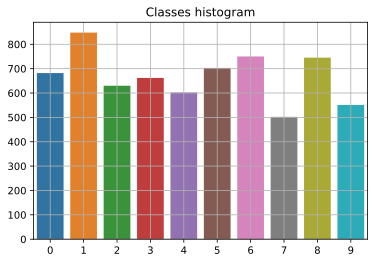

CPU times: user 1min 12s, sys: 4.21 s, total: 1min 17s
Wall time: 1min 6s


In [65]:
%%time
predictions = get_predictions(model, False)
predictions_dict['best_wo_tta'] = predictions
print(predictions.shape)
print(predictions.argmax(axis=-1).shape)
km.plot_classes_hist(predictions.argmax(axis=-1))

Далее для той же лучшей модели получим предсказание с применением TTA

209/209 [==============================] - 102s 490ms/step
(6675, 10)
(6675,)


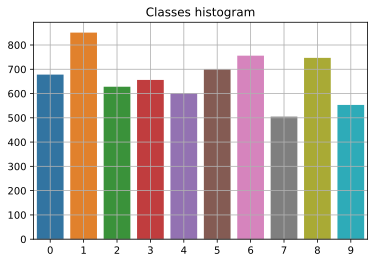

CPU times: user 19min 21s, sys: 36.7 s, total: 19min 58s
Wall time: 17min 4s


In [66]:
%%time
predictions, predictions_arr = get_predictions(model, True, True)
predictions_dict['best_tta'] = predictions
print(predictions.shape)
print(predictions.argmax(axis=-1).shape)
km.plot_classes_hist(predictions.argmax(axis=-1))

Сделаем предсказания 3 раза. Нулевая ось - номер попытки, первая ось - номер изображения, вторая ось - номер класса. Теперь нам нужно сделать усреднение по номеру попытки, а затем argmax по номеру класса. 
<br>
Также можем посмотреть насколько совпали предсказания на каждом изображении с разными аугментациями (цвет на изображении означает класс):

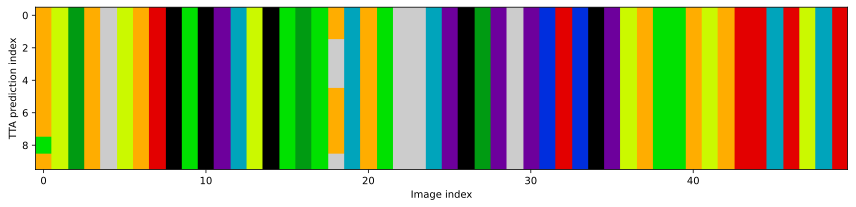

In [78]:
plt.figure(figsize=(15, 3))
plt.imshow(predictions_arr.argmax(axis=-1)[:, :50], cmap='nipy_spectral')
plt.xlabel('Image index')
plt.ylabel('TTA prediction index')
plt.show()

Далее подгрузим модель с последней эпохи обучения (не обязательно лучшую), и сделаем предсказания на тестовых данных применяя TTA

In [68]:
model_name = 'model_epoch_' + str(EPOCHS-1) + '.h5'
print(model_name)
model.load_weights(MODELS_PATH+model_name)
model.compile(loss=CategoricalCrossentropy(from_logits=True),
              optimizer=Adam(ExponentialDecay(LR, 100, 0.9), amsgrad=True),
              metrics='accuracy')

model_epoch_9.h5


209/209 [==============================] - 102s 487ms/step
(6675, 10)
(6675,)


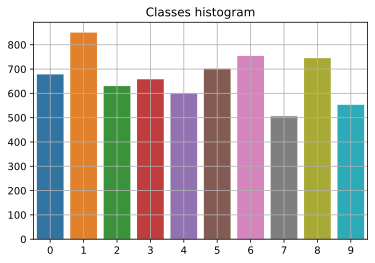

CPU times: user 19min 27s, sys: 37.9 s, total: 20min 5s
Wall time: 17min 11s


In [69]:
%%time
predictions, predictions_arr = get_predictions(model, True, True)
predictions_dict['last_tta'] = predictions
print(predictions.shape)
print(predictions.argmax(axis=-1).shape)
km.plot_classes_hist(predictions.argmax(axis=-1))

Далее применим простой способ ансамблирования - усреднение предсказаний нескольких моделей (например, лучшей и последней).
<br>
Скорее всего таким образом удасться увеличить точность предсказаний, но не обязательно

(2, 6675, 10)
(6675, 10)
(6675,)


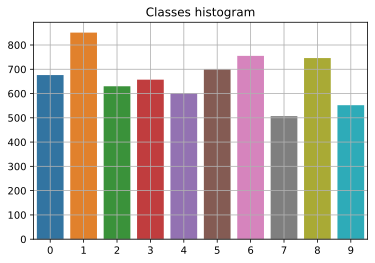

In [70]:
predictions = np.array([predictions_dict['best_tta'], predictions_dict['last_tta']])
predictions_average = predictions.mean(axis=0)
predictions_dict['average_tta'] = predictions_average
print(predictions.shape)
print(predictions_average.shape)
print(predictions_average.argmax(axis=-1).shape)
km.plot_classes_hist(predictions_average.argmax(axis=-1))

In [71]:
# print(gc.isenabled())
# del base_model
# del model
# gc.collect()
# # скидываем сессию
# K.clear_session()

In [72]:
# Очистим рабочие директории, чтобы не помешали сохранить CSV файлы с предсказаниями
km.clear_directory(PATH)
km.clear_directory(MODELS_PATH)
print(os.listdir('../working/'))

['requirements.txt', '.virtual_documents', '__notebook_source__.ipynb']


Сохраним несколько вариантов предсказаний для submission, чтобы выбрать лучший из них

In [73]:
for filename, predictions in predictions_dict.items():
    save_predictions_to_csv(predictions, 'submission_'+filename)